# 254p Thermal Images EDA Code

### Importing the Data

In [1]:
#Relevant Libraries
from pathlib import Path
import pandas as pd
import cv2
import os
import re
import numpy as np
from PIL import Image
from IPython.display import Image as Image_dis
import hvplot.pandas
import matplotlib.pyplot as plt

In [2]:
# Set path to the directory containing the Thermal images
path = "C:\\Users\\ConnorRoth\\Documents\\Grad School\\Spring 2023\\DSCI 591\\Datasets\\FLAME 2\\254p Thermal Images"

In [3]:
#Install OpenCV package: https://pypi.org/project/opencv-python/
!pip install opencv-python
#Install HVPlot package: https://hvplot.holoviz.org/user_guide/Pandas_API.html
!pip install hvplot

In [4]:
#Create a function to tokenize the file name strings, returning a unique id and type of file
def tokenize_file_name(file_path, file_name):
    tokens = re.split(" ", file_name)
    file_id = tokens[-1].replace('(','').replace(')','').replace('.jpg','')
    file_color = tokens[1]
    file_type = Path(file_path).suffix
    
    return file_id, file_color, file_type

#Create a function to grab the dimensions (pixels) and channels (color or b&w) of files
def get_dimensions_and_channels(file_path):
    image = cv2.imread(file_path)
    height, width, channel = image.shape
    
    return height, width, channel

#Create a function to turn an image into a numpy array (for analysis)
def image_to_array(file_string):
    # Open the image file
    image = Image.open(file_string)
    # Convert the image to a numpy array
    img_array = np.array(image)
    
    return img_array

#Create a function that does all of the collection / aggregation for a given path
def collect_aggregate_data(file_dir):
    metadata = []
    images = []
    
    for item in os.listdir(file_dir):
        item_name = item
        item_path = os.path.join(file_dir, item)
        item_id, item_color, item_type = tokenize_file_name(item_path, item)
        item_height, item_width, item_channel = get_dimensions_and_channels(item_path)
        item_array = image_to_array(item_path)

        metadata.append([item_id, item_color, item_type, item_height, item_width, item_channel, item_name, item_path])
        images.append(item_array)
            
    return metadata, images

In [5]:
### DATA COLLECTION/AGGREGATION ###
metadata = []
images = []

metadata, images = collect_aggregate_data(path)

FORMAT: FirstFrameNumber - LastFrameNumber Fire(Y/N)Smoke(Y/N)
1. Fire (Y/N) indicates whether or not there is fire visible in 254p RGB and/or 254p Thermal frame
2. Smoke (Y/N) indicates whether smoke fills >= 50% of the 254p RGB frame (visual estimate)

- 1-13700: NN
- 13700-14699: YY
- 14700-15980: YN
- 15981-19802: YY
- 19803-19899: YN
- 19900-27183: YY
- 27184-27514: YN
- 27515-31294: YY
- 31295-31509: YN
- 31510-33597: YY
- 33598-33929: YN
- 33930-36550: YY
- 36551-38030: YN
- 38031-38153: YY
- 38154-41642: YN
- 41642-45279: YY
- 45280-51206: YN
- 51207-52286: YY
- 52287-53451: YN

In [6]:
#Assembling Labels for dataframe
numbers = [x for x in range(1,53451+1)]

def fire_filter(i):
    if i > 13700:
        return "Fire"
    else:
        return "No_Fire"

def smoke_filter(i):
    if (((i > 13700) & (i <= 14699)) | \
            ((i >= 15981) & (i <= 19802)) | \
            ((i >= 19900) & (i <= 27183)) | \
            ((i >= 27515) & (i <= 31294)) | \
            ((i >= 31510) & (i <= 33597)) | \
            ((i >= 33930) & (i <= 36550)) | \
            ((i >= 38031) & (i <= 38153)) | \
            ((i >= 41642) & (i <= 45279)) | \
            ((i >= 51207) & (i <= 52286))):
        return "Smoke"
    else:
        return "No_Smoke"
    
fire_label = [fire_filter(i) for i in numbers]
smoke_label = [smoke_filter(i) for i in numbers]

In [7]:
### DATAFRAME, IMAGE ARRAY CREATION ###
df = pd.DataFrame(metadata, columns=['id', 'color', 'file_type', 'pixel_height', 'pixel_width', 
                                       'image_channels', 'file_name', 'file_path'])
df["fire_label"] = fire_label
df["smoke_label"] = smoke_label

img_array = np.array(images)

In [8]:
### Examine dataframe head ###
df.head(5)

id    color file_type  pixel_height  pixel_width  image_channels  \
0      1  Thermal      .jpg           254          254               3   
1     10  Thermal      .jpg           254          254               3   
2    100  Thermal      .jpg           254          254               3   
3   1000  Thermal      .jpg           254          254               3   
4  10000  Thermal      .jpg           254          254               3   

                        file_name  \
0      254p Thermal Frame (1).jpg   
1     254p Thermal Frame (10).jpg   
2    254p Thermal Frame (100).jpg   
3   254p Thermal Frame (1000).jpg   
4  254p Thermal Frame (10000).jpg   

                                           file_path fire_label smoke_label  
0  C:\Users\ConnorRoth\Documents\Grad School\Spri...    No_Fire    No_Smoke  
1  C:\Users\ConnorRoth\Documents\Grad School\Spri...    No_Fire    No_Smoke  
2  C:\Users\ConnorRoth\Documents\Grad School\Spri...    No_Fire    No_Smoke  
3  C:\Users\ConnorRoth\Documents\Grad School\Spri...    No_Fire    No_Smoke  
4  C:\Users\ConnorRoth\Documents\Grad School\Spri...    No_Fire    No_Smoke

In [9]:
### Examine Shape of Image Array ###
print("Training Image array shape:", img_array.shape)

Training Image array shape: (53451, 254, 254, 3)


### View Sampling of Images

In [10]:
## Create a function to show random sampling of 10 images
def show_random_sampling(image_array):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
    for i, ax in enumerate(axes.flat):
        rand_index = np.random.randint(len(image_array))
        ax.imshow(image_array[rand_index])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("Image {}".format(rand_index+1))
    plt.tight_layout()
    plt.show()


#Create a function to show specific images
def show_image(title, image_1_fp, image_2_fp):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    image_1 = image_to_array(image_1_fp)
    image_2 = image_to_array(image_2_fp)
    
    axes[0].imshow(image_1)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title(title)
    
    axes[1].imshow(image_2)
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title(title)
    
    plt.tight_layout()
    plt.show()

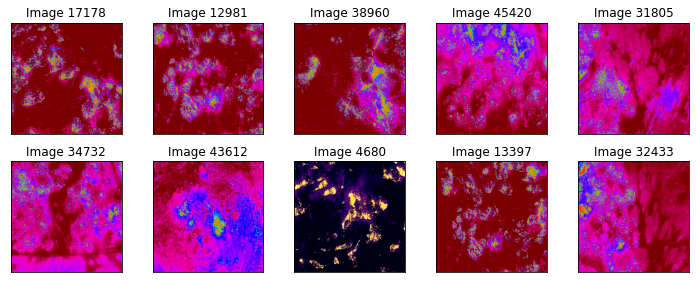

In [11]:
## Explore random sampling of 10 images
show_random_sampling(img_array)

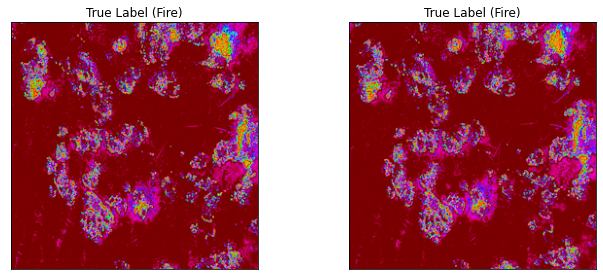

In [12]:
## Explore TRUE FIRE labels
fire_subset = df[df.fire_label == "Fire"]

#Show two FIRE images
show_image("True Label (Fire)", fire_subset.iloc[10]["file_path"], fire_subset.iloc[1000]["file_path"])

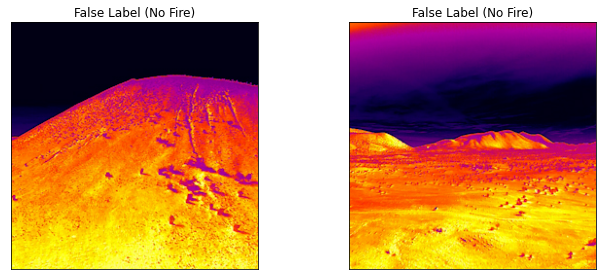

In [13]:
## Explore NO FIRE labels
no_fire_subset = df[df.fire_label == "No_Fire"]

#Show two NO FIRE images
show_image("False Label (No Fire)", no_fire_subset.iloc[10]["file_path"], no_fire_subset.iloc[1000]["file_path"])

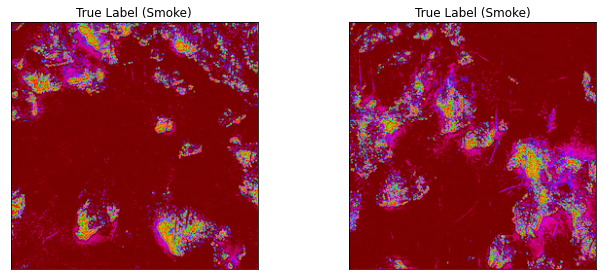

In [14]:
## Explore SMOKE Labels
smoke_subset = df[df.smoke_label == "Smoke"]

#Show two SMOKE images
show_image("True Label (Smoke)", smoke_subset.iloc[5000]["file_path"], smoke_subset.iloc[1500]["file_path"])

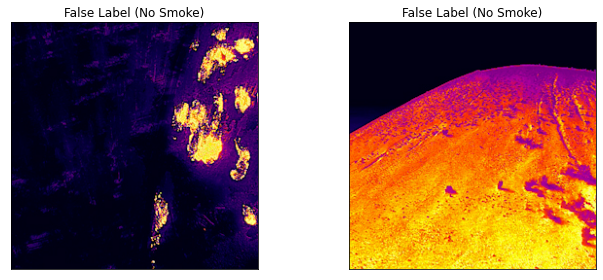

In [15]:
## Explore NO SMOKE Labels
no_smoke_subset = df[df.smoke_label == "No_Smoke"]

#Show two Smoke images
show_image("False Label (No Smoke)", no_smoke_subset.iloc[6000]["file_path"], no_smoke_subset.iloc[500]["file_path"])

### Examine Image Sizing (Graphically)

In [16]:
## Check height, width, and channels
print("DATASET Unique Values:")
print("Pixel Height:", df["pixel_height"].unique())
print("Pixel Width:", df["pixel_width"].unique())
print("Image Channels:", df["image_channels"].unique())
print()

DATASET Unique Values:
Pixel Height: [254]
Pixel Width: [254]
Image Channels: [3]



In [17]:
## Graphing height against width
sizes = df.groupby(['pixel_height', 'pixel_width']).size().reset_index().rename(columns={0:'count'})
sizes.hvplot.scatter(x='pixel_height', y='pixel_width', size='count', xlim=(0,1200), ylim=(0,1200), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(line_alpha=1, fill_alpha=0.3)

:Scatter   [pixel_height]   (pixel_width,count)

In [18]:
def analyze_image_dimensions(df):
    # Calculate aspect ratio
    df['aspect_ratio'] = df['pixel_width'] / df['pixel_height']
 
    # Plot histogram of aspect ratios
    plt.hist(df['aspect_ratio'], bins=30, color='orange')
    plt.title("Distribution of Aspect Ratios")
    plt.xlabel("Aspect Ratio")
    plt.ylabel("Frequency")
    plt.show()
 
    # Print summary statistics
    print("Aspect Ratio:")
    print(f"Minimum: {df['aspect_ratio'].min()}")
    print(f"Maximum: {df['aspect_ratio'].max()}")
    print(f"Mean: {df['aspect_ratio'].mean()}")
    print(f"Median: {df['aspect_ratio'].median()}")
    print(f"Standard Deviation: {df['aspect_ratio'].std()}")

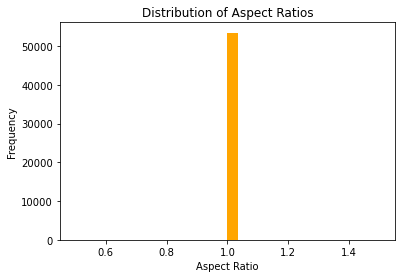

Aspect Ratio:
Minimum: 1.0
Maximum: 1.0
Mean: 1.0
Median: 1.0
Standard Deviation: 0.0


In [19]:
analyze_image_dimensions(df)

### Examine Image Label Distribution

In [20]:
# Examine fire label values
df["fire_label"].value_counts()

Fire       39751
No_Fire    13700
Name: fire_label, dtype: int64

In [21]:
# Examine smoke label values
df["smoke_label"].value_counts()

No_Smoke    28016
Smoke       25435
Name: smoke_label, dtype: int64

<AxesSubplot:title={'center':'FLAME 2 Dataset: FIRE Label Counts'}, xlabel='Fire_Label', ylabel='Count'>

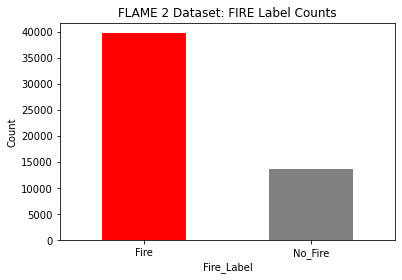

In [22]:
#Examine fire label graphically
df["fire_label"].value_counts().plot(kind='bar', xlabel = "Fire_Label", ylabel = "Count", 
                                      rot=0, title = "FLAME 2 Dataset: FIRE Label Counts", color = ['red', 'grey'])

<AxesSubplot:title={'center':'FLAME 2 Dataset: SMOKE Label Counts'}, xlabel='Smoke_Label', ylabel='Count'>

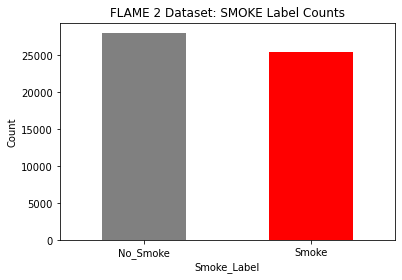

In [23]:
#Examine smoke label graphically
df["smoke_label"].value_counts().plot(kind='bar', xlabel = "Smoke_Label", ylabel = "Count", 
                                      rot=0, title = "FLAME 2 Dataset: SMOKE Label Counts", color = ['grey', 'red'])

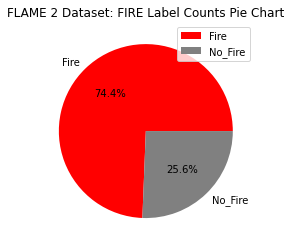

In [24]:
#Examine fire label graphically
plt.pie(df["fire_label"].value_counts(), labels = ["Fire", "No_Fire"], autopct='%1.1f%%', 
        colors = ['red', 'grey'])
plt.title("FLAME 2 Dataset: FIRE Label Counts Pie Chart")
plt.legend(loc='upper right')
plt.show() 

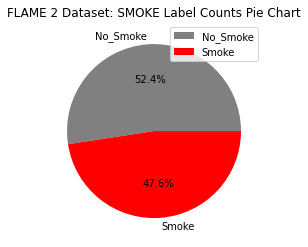

In [25]:
#Examine smoke label graphically
plt.pie(df["smoke_label"].value_counts(), labels = ["No_Smoke", "Smoke"], autopct='%1.1f%%',
        colors = ['grey', 'red'])
plt.title("FLAME 2 Dataset: SMOKE Label Counts Pie Chart")
plt.legend(loc='upper right')
plt.show() 

In [26]:
# Examine overlap of labels

label_crosstab = pd.crosstab(df.fire_label, df.smoke_label)
label_crosstab

smoke_label  No_Smoke  Smoke
fire_label                  
Fire            14316  25435
No_Fire         13700      0

### Examine Pixel Data (RGB channels) Overall, by Label

In [41]:
# Create a graphing function for a histogram of red/blue/green channel values
def plot_channel_values(title, image_array, channel, color):
    plt.hist(image_array[:,:,channel].ravel(), bins=256, color = color)
    plt.title(title)
    plt.xlabel(color + ' intensity')
    plt.ylabel('Frequency')
    plt.ylim([0, 950000])
    plt.show()

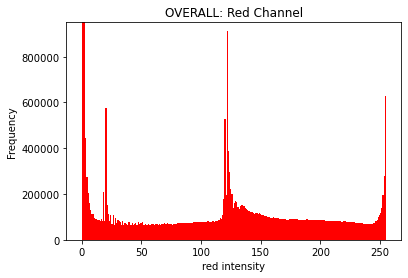

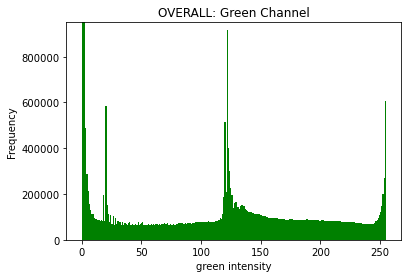

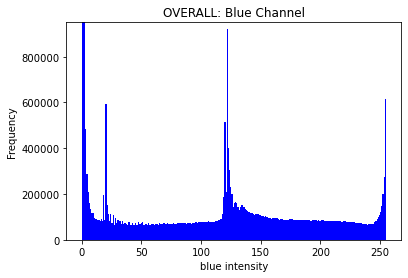

In [42]:
# OVERALL: Red Channel
plot_channel_values("OVERALL: Red Channel", img_array, 0, 'red')

# OVERALL: Green Channel
plot_channel_values("OVERALL: Green Channel", img_array, 1, 'green')

# OVERALL: Blue Channel
plot_channel_values("OVERALL: Blue Channel", img_array, 2, 'blue')

In [43]:
# Create a specific graphing function for side-by-side comparision of red/blue/green channel values (label evaluation)
def plot_channel_values_by_label(title, image_array_true, image_array_false, channel, color, ymax):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].hist(image_array_true[:,:,channel].ravel(), bins = 256, color = color)
    ax[0].set_ylim([0,ymax])
    ax[0].set_title("True Label: " + title)
    ax[0].set_xlabel(color + ' intensity')
    ax[0].set_ylabel('Frequency')
    
    ax[1].hist(image_array_false[:,:,channel].ravel(), bins = 256, color = color)
    ax[1].set_ylim([0,ymax])
    ax[1].set_title("False Label: " + title)
    ax[1].set_xlabel(color + ' intensity')
    ax[1].set_ylabel('Frequency')

    plt.show()

In [44]:
# Create masks based on the dataframe assembled
fire_mask = (df["fire_label"] == "Fire")
no_fire_mask = (df["fire_label"] == "No_Fire")

# Create subset of img arrays for our "Fire" vs "No_Fire" histogram comparison
fire_img_array = img_array[fire_mask]
no_fire_img_array = img_array[no_fire_mask]

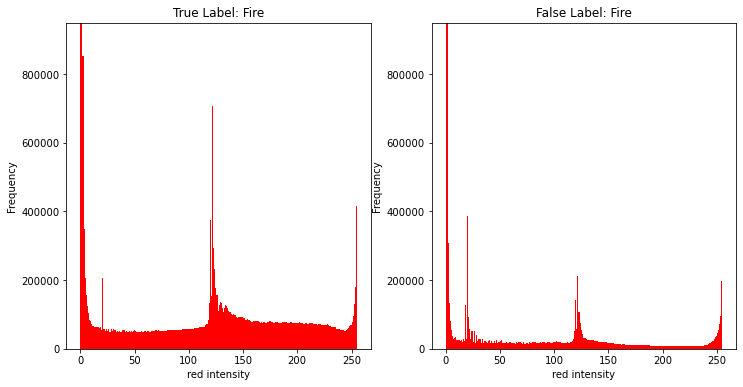

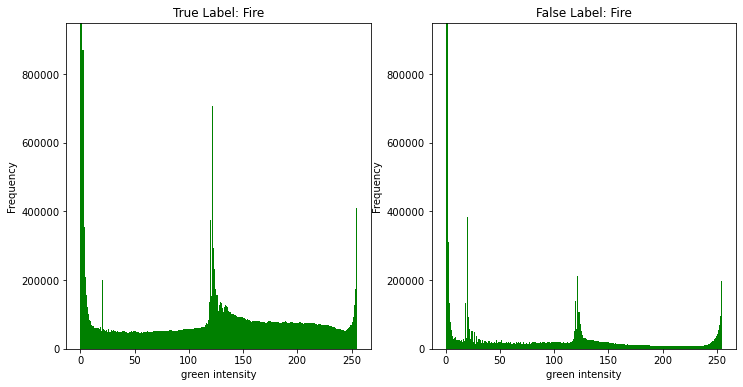

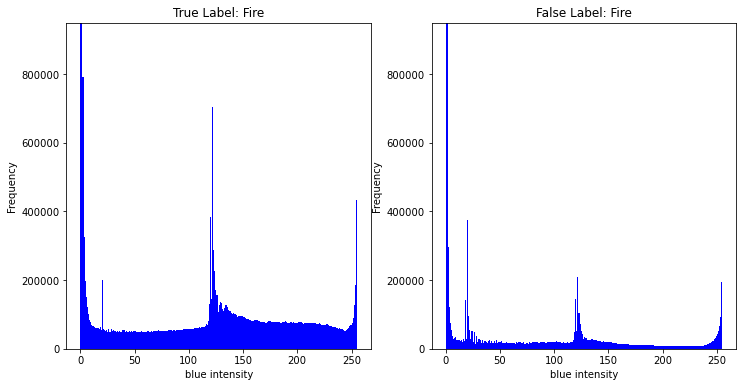

In [46]:
# Red Channel
plot_channel_values_by_label("Fire", fire_img_array, no_fire_img_array, 2, 'red', 950000)

# Green Channel
plot_channel_values_by_label("Fire", fire_img_array, no_fire_img_array, 1, 'green', 950000)

# Blue Channel
plot_channel_values_by_label("Fire", fire_img_array, no_fire_img_array, 0, 'blue', 950000)

In [47]:
# Create masks based on the dataframe assembled
smoke_mask = (df["smoke_label"] == "Smoke")
no_smoke_mask = (df["smoke_label"] == "No_Smoke")

# Create subset of img arrays for our "Smoke" vs "No_Smoke" histogram comparison
smoke_img_array = img_array[smoke_mask]
no_smoke_img_array = img_array[no_smoke_mask]

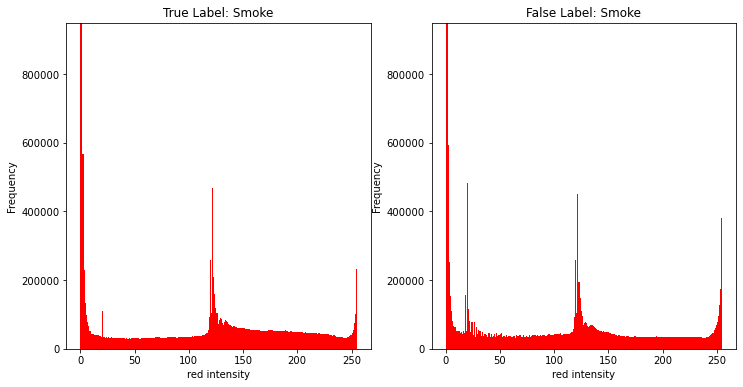

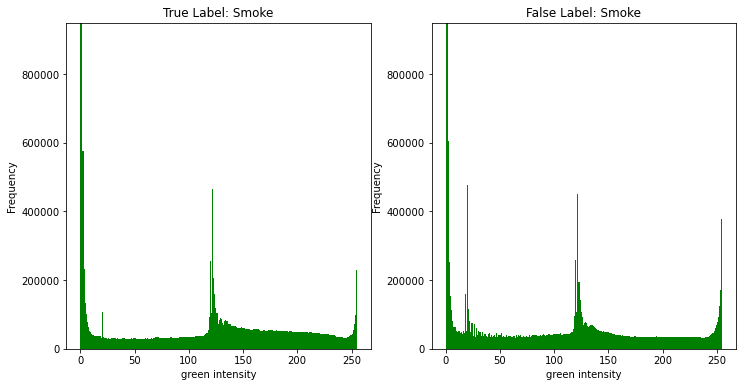

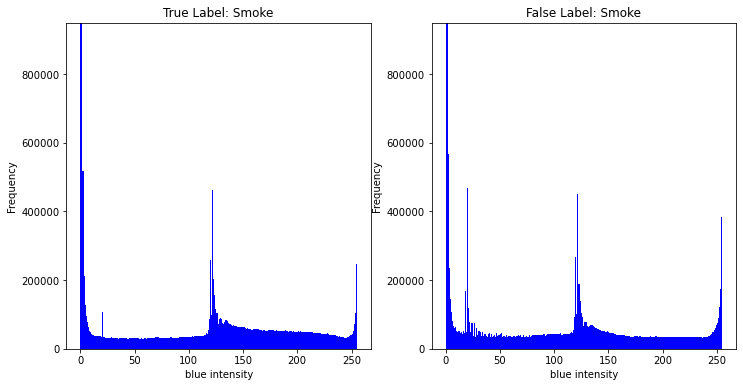

In [50]:
# Red Channel
plot_channel_values_by_label("Smoke", smoke_img_array, no_smoke_img_array, 2, 'red', 950000)

# Green Channel
plot_channel_values_by_label("Smoke", smoke_img_array, no_smoke_img_array, 1, 'green', 950000)

# Blue Channel
plot_channel_values_by_label("Smoke", smoke_img_array, no_smoke_img_array, 0, 'blue', 950000)

### Compute "Mean Image"

In [51]:
# Create average image by calculating the mean pixel intensities
def average_image_data(image_array):
    average_image = np.zeros((254, 254, 3), dtype=float)
    N = len(image_array)
    
    for index in range(N):
        average_image += image_array[index] / N
    
    average_image = np.array(np.round(average_image), dtype=np.uint8)
    
    return average_image

# Creating a function to generate, save, and show the resultant image
def show_average_image(average_image, title):
    output = Image.fromarray(average_image, mode="RGB")
    plt.imshow(output)
    plt.title(title)
    plt.xlabel("Pixel width")
    plt.ylabel("Pixel height")
    plt.show()

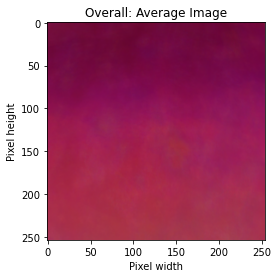

In [52]:
# Overall: Average Image
overall_avg_img = average_image_data(img_array)
show_average_image(overall_avg_img, "Overall: Average Image")

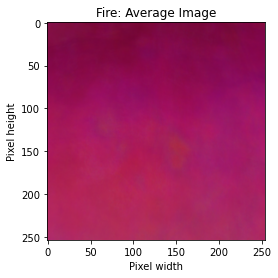

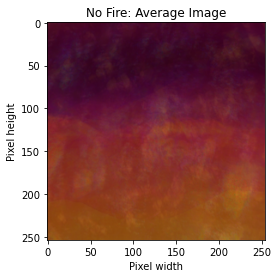

In [53]:
# FIRE: Average Image
fire_avg_img = average_image_data(fire_img_array)
show_average_image(fire_avg_img, "Fire: Average Image")

# NO FIRE: Average Image
no_fire_avg_img = average_image_data(no_fire_img_array)
show_average_image(no_fire_avg_img, "No Fire: Average Image")

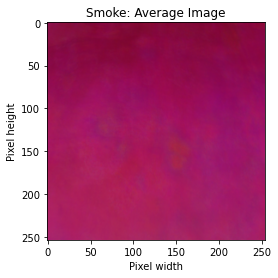

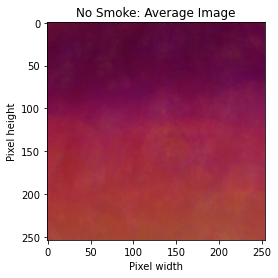

In [54]:
# SMOKE: Average Image
smoke_avg_img = average_image_data(smoke_img_array)
show_average_image(smoke_avg_img, "Smoke: Average Image")

# NO SMOKE: Average Image
no_smoke_avg_img = average_image_data(no_smoke_img_array)
show_average_image(no_smoke_avg_img, "No Smoke: Average Image")